In [1]:
import os
import glob
import random
import sys
# import from absolute directory
srcdir = '/Users/pengzhizhang/cellDancer/src'
sys.path.append(srcdir)

import matplotlib.pyplot as plt
import pandas as pd

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import *
import anndata

from scipy.integrate import solve_ivp

def _generate_points(u0_start, s0_start, alpha, beta, gamma, t1, t2, samples):

    def trans_dynamics(t, expr): 
        s = expr[0]
        u = expr[1]
        du_dt = alpha - beta*u
        ds_dt = beta*u - gamma*s
        return [ds_dt, du_dt]

    #print("t1 and t2:", t1, t2)
    t_space = np.linspace(t1, t2, samples)
    num_sol = solve_ivp(trans_dynamics, [0, t2], [s0_start, u0_start], method='RK45', dense_output=True)
    XY_num_sol = num_sol.sol(t_space)
    S, U = XY_num_sol[0], XY_num_sol[1]
    return U, S

def _jitter(U, S, scale):
    S = S + np.random.normal(loc=0.0, scale=scale*np.percentile(S, 99) / 10, size=np.size(S))
    U = U + np.random.normal(loc=0.0, scale=scale*np.percentile(U, 99) / 10, size=np.size(U))
    S1 = S[(S>0)&(U>0)]
    U1 = U[(S>0)&(U>0)]
    S1, U1 = np.clip(S, 0, None), np.clip(U, 0, None)
    return U1, S1

def _simulate(u0_start, s0_start, alpha, beta, gamma, t1, t2, samples, dt=0.001, scale=1):
    u0, s0 = _generate_points(u0_start, s0_start, alpha, beta, gamma, t1, t2, samples)
    u0_end, s0_end = u0[-1], s0[-1]
    #u0, s0 = _jitter(u0, s0, scale)
    u1 = u0 + (alpha - beta*u0)*dt
    s1 = s0 + (beta*u0 - gamma*s0)*dt

    expr = pd.DataFrame(u0, columns=['u0'])
    expr['s0'] = s0
    expr['u1'] = u1
    expr['s1'] = s1
    expr['alpha'] = alpha
    expr['beta'] = beta
    expr['gamma'] = gamma
    return expr, (u0_end, s0_end)

def _simulate_without_t( u0_start, s0_start, alpha, beta, gamma, percent_start_u, percent_end_u, samples, dt=0.001, scale=1):
    '''percentage_u: u_end/u_max'''

    def inversed_u(u, expr): 
        t = expr[0]
        dt_du = 1/(alpha - beta*u)
        return dt_du

    if alpha != 0:
        u_max = alpha/beta
        u_start = u0_start + (u_max-u0_start) * percent_start_u/100
        u_end = u0_start + (u_max-u0_start)  * percent_end_u/100
    else:
        u_max = u0_start
        u_start = u_max * (100-percent_start_u)/100
        u_end = u_max * (100-percent_end_u)/100

    t_sol = solve_ivp(inversed_u, [u0_start, u_end], [0], method='RK45', dense_output=True)
    t1 = t_sol.sol(u_start)[0]  
    t2 = t_sol.sol(u_end)[0]  
    return _simulate(u0_start, s0_start, alpha, beta, gamma, t1, t2, samples, dt, scale)

def forward(alpha, beta, gamma, percent_u1, percent_u2, samples, dt=0.001, noise_level=1):
    expr, end = _simulate_without_t(0, 0, alpha, beta, gamma, percent_u1, percent_u2, samples, dt, noise_level)
    return expr

def backward(alpha, beta, gamma, percent_u1, percent_u2, samples, dt=0.001, noise_level=1):
    u0_start = alpha/beta
    s0_start = alpha/gamma
    expr, end = _simulate_without_t(u0_start, s0_start, 0, beta, gamma, percent_u1, percent_u2, samples, dt, noise_level)
    return expr

def two_alpha(alpha1, alpha2, beta1, beta2, gamma1, gamma2, percent_u1, percent_u2, samples1, samples2, dt=0.001, noise_level=1):
    expr1, (new_u0_start, new_s0_start) = _simulate_without_t(0, 0, alpha1, beta1, gamma1, 0, percent_u1, samples1, dt, noise_level)
    expr2, end2  = _simulate_without_t(new_u0_start, new_s0_start, alpha2, beta2, gamma2, 0, percent_u2, samples2, dt, noise_level)
    expr = expr1.append(expr2)
    expr.index = range(len(expr))
    return expr

def two_alpha2(alpha1, alpha2, beta1, beta2, gamma1, gamma2, percent_u1, percent_u2, samples1, samples2, dt=0.001, noise_level=1):
    expr1, end1 = _simulate_without_t(0, 0, alpha1, beta1, gamma1, 0, percent_u1, samples1, dt, noise_level)
    expr2, end2  = _simulate_without_t(0, 0, alpha2, beta2, gamma2, 0, percent_u2, samples2, dt, noise_level)
    expr = expr1.append(expr2)
    expr.index = range(len(expr))
    return expr

def two_alpha3(alpha1, alpha2, beta1, beta2, gamma1, gamma2, percent_u1, percent_u2, samples1, samples2, dt=0.001, noise_level=0.02):
    exprx, (new_u0_start, new_s0_start) = _simulate_without_t(0, 0, alpha2, beta2, gamma2, 0, 99.9, samples2, dt, noise_level)
    expr1, (new_u0_start2, new_s0_start2)  = _simulate_without_t(new_u0_start, new_s0_start, alpha1, beta1, gamma1, 0, percent_u1, samples1, dt, noise_level)
    expr2, end1  = _simulate_without_t(new_u0_start2, new_s0_start2, alpha2, beta2, gamma2, 0, percent_u2, samples2, dt, noise_level)
    expr = expr1.append(expr2)
    expr.index = range(len(expr))
    return expr

def generate_with_df(gene_info, dt=0.001, noise_level=0.2):
    expr = pd.DataFrame()
    last_u, last_s = None, None
    for i in range(len(gene_info.index)):
        gene_name, start_u, start_s = gene_info['gene_name'][i], gene_info['start_u'][i], gene_info['start_s'][i]
        alpha, beta, gamma = gene_info['alpha'][i], gene_info['beta'][i], gene_info['gamma'][i]
        start_pct, end_pct, samples = gene_info['start_pct'][i], gene_info['end_pct'][i], gene_info['samples'][i]
        if start_u is not None and start_s is not None:
            expr_tmp, (last_u, last_s) = _simulate_without_t(start_u, start_s, alpha, beta, gamma, start_pct, end_pct, samples)
        else:
            if last_u is None or last_s is None:
                print("start_u and start_s should not be None at the first line.")
                return None
            expr_tmp, (last_u, last_s) = _simulate_without_t(last_u, last_s, alpha, beta, gamma, start_pct, end_pct, samples)
        expr = expr.append(expr_tmp)
    expr.index = range(len(expr))
    expr.u0, expr.s0 = _jitter(expr.u0, expr.s0, noise_level)
    return gene_info, expr

def adata_to_detail(data, para, gene):
    data2 = data[:, data.var.index.isin([gene])].copy()
    u0 = data2.layers[para[0]][:,0].copy().astype(np.float32)
    s0 = data2.layers[para[1]][:,0].copy().astype(np.float32)
    alpha = data2.layers[para[2]][:,0].copy().astype(np.float32)
    beta = data2.layers[para[3]][:,0].copy().astype(np.float32)
    gamma = data2.layers[para[4]][:,0].copy().astype(np.float32)
    detail = pd.DataFrame({'gene_list':gene, 'u0':u0, 's0':s0, 'embedding1':u0, 'embedding2':s0, 'alpha':alpha, 'beta':beta, 'gamma':gamma})
    #detail['beta1'] = data2.var['beta1'].to_numpy()[0]
    #detail['beta2'] = data2.var['beta2'].to_numpy()[0]
    #detail['gamma1'] = data2.var['gamma1'].to_numpy()[0]
    #detail['gamma2'] = data2.var['gamma2'].to_numpy()[0]
    detail['path1_pct'] = data2.var['path1_pct'].to_numpy()[0]
    detail['path2_pct'] = data2.var['path2_pct'].to_numpy()[0]
    return(detail)

def generate(type, gene_num, alpha1, alpha2, beta1, beta2, gamma1, gamma2, path1_pct, path2_pct, path1_sample, path2_sample, noise_level):
    cell_num=path1_sample+path2_sample
    u0s, s0s, u1s, s1s, alphas, betas, gammas = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    gene_info = pd.DataFrame(columns = ['gene_name', 'type', 'alpha1', 'alpha2', 'beta1', 'beta2', 'gamma1', 'gamma2', 'path1_pct', 'path2_pct', 'samples'])
    
    for i in range(gene_num):
        samples1, samples2 = path1_sample, path2_sample
        if type == "forwad":
            expr = forward(alpha=alpha1, beta=beta1, gamma=gamma1, percent_u1=0.1, percent_u2=99.9,  samples=samples1, noise_level=noise_level)
        elif type == "backward":
            expr = backward(alpha=alpha1, beta=beta1, gamma=gamma1, percent_u1=0.1, percent_u2=99.9,  samples=samples1, noise_level=noise_level)
        elif type == "two_alpha":
            expr = two_alpha(alpha1=alpha1, alpha2=alpha2, beta1=beta1, beta2=beta2, gamma1=gamma1, gamma2=gamma2, percent_u1=path1_pct, percent_u2=path2_pct, 
                    samples1=samples1, samples2=samples2, noise_level=noise_level)
        elif type == "two_alpha2":
            expr = two_alpha2(alpha1=alpha1, alpha2=alpha2, beta1=beta1, beta2=beta2, gamma1=gamma1, gamma2=gamma2, percent_u1=path1_pct, percent_u2=path2_pct, 
                    samples1=samples1, samples2=samples2, noise_level=noise_level)
        elif type == "two_alpha3":
            expr = two_alpha3(alpha1=alpha1, alpha2=alpha2, beta1=beta1, beta2=beta2, gamma1=gamma1, gamma2=gamma2, percent_u1=path1_pct, percent_u2=path2_pct, 
                    samples1=samples1, samples2=samples2, noise_level=noise_level)
        else:
            print("type not match")
        expr.u0, expr.s0 = _jitter(expr.u0, expr.s0, noise_level)
        expr = expr.head(cell_num)
        gene_name = "simulation"+str(i).zfill(3)
        u0s[gene_name] = expr.u0
        s0s[gene_name] = expr.s0
        u1s[gene_name] = expr.u1
        s1s[gene_name] = expr.s1
        alphas[gene_name] = expr.alpha
        betas[gene_name] = expr.beta
        gammas[gene_name] = expr.gamma
        gene_info = gene_info.append({'gene_name':gene_name, 'type':"multi_path", 'alpha1':alpha1, 'alpha2':alpha2, 'beta1':beta1, 'beta2':beta2, 'gamma1':gamma1, 'gamma2':gamma2, 'path1_pct':path1_pct, 'path2_pct':path2_pct, 'samples':len(expr)}, ignore_index=True)

    #gene_info.set_index("gene_name")
    cell_info = pd.DataFrame()
    cell_info['barcode'] = s0s.index
    adata = anndata.AnnData(
        X=s0s.to_numpy(),
        obs = cell_info,
        var = gene_info,
        layers = {
            'u0s':u0s.to_numpy(),
            's0s': s0s.to_numpy(),
            'u1s':u1s.to_numpy(),
            's1s': s1s.to_numpy(),
            'alphas': alphas.to_numpy(),
            'betas': betas.to_numpy(),
            'gammas': gammas.to_numpy() }
    )
    adata.var_names = gene_info['gene_name']

    genelist_all=adata.var_names
    data_onegene = pd.DataFrame()
    for g in genelist_all:
        data_onegene = data_onegene.append(adata_to_detail(adata, para=['u0s', 's0s', 'alphas', 'betas', "gammas"], gene=g))
    return data_onegene

def generate_forward(gene_num, alpha, beta, gamma, sample, noise_level):
    return generate("forwad", gene_num, alpha, 0, beta, 0, gamma, 0, 0, 0, sample, 0, noise_level)

def generate_backward(gene_num, alpha, beta, gamma, sample, noise_level):
    return generate("backward", gene_num, alpha, 0, beta, 0, gamma, 0, 0, 0, sample, 0, noise_level)

def generate_onepath(gene_num, alpha1, alpha2, beta1, beta2, gamma1, gamma2, path1_pct, path2_pct, path1_sample, path2_sample, noise_level):
    return generate("two_alpha", gene_num, alpha1, alpha2, beta1, beta2, gamma1, gamma2, path1_pct, path2_pct, path1_sample, path2_sample, noise_level)

def generate_multipath(gene_num, alpha1, alpha2, beta1, beta2, gamma1, gamma2, path1_pct, path2_pct, path1_sample, path2_sample, noise_level):
    return generate("two_alpha2", gene_num, alpha1, alpha2, beta1, beta2, gamma1, gamma2, path1_pct, path2_pct, path1_sample, path2_sample, noise_level)

def generate_float_circle(gene_num, alpha1, alpha2, beta1, beta2, gamma1, gamma2, path1_pct, path2_pct, path1_sample, path2_sample, noise_level):
    return generate("two_alpha3", gene_num, alpha1, alpha2, beta1, beta2, gamma1, gamma2, path1_pct, path2_pct, path1_sample, path2_sample, noise_level)

def generate_2circle():
    gene_info = pd.DataFrame(columns = ['gene_name', 'start_u', 'start_s', 'alpha', 'beta', 'gamma', 'start_pct', 'end_pct', 'samples'])
    gene_info = gene_info.append({'gene_name':'g1', 'start_u':0, 'start_s':0, 'alpha':15, 'beta':10, 'gamma':12, 'start_pct':0, 'end_pct':99, 'samples':1000}, ignore_index=True)
    gene_info = gene_info.append({'gene_name':'g1', 'start_u':None, 'start_s':None, 'alpha':0, 'beta':10, 'gamma':12, 'start_pct':0, 'end_pct':99, 'samples':1000}, ignore_index=True)
    gene_info = gene_info.append({'gene_name':'g1', 'start_u':0, 'start_s':0, 'alpha':25, 'beta':10, 'gamma':10, 'start_pct':0, 'end_pct':70, 'samples':1000}, ignore_index=True)
    gene_info = gene_info.append({'gene_name':'g1', 'start_u':None, 'start_s':None, 'alpha':0, 'beta':10, 'gamma':10, 'start_pct':0, 'end_pct':99, 'samples':1000}, ignore_index=True)
 
    gene_info, expr = generate_with_df(gene_info)
    plt.scatter(expr['s0'], expr['u0'], c=expr['alpha'], s=1)
    plt.show()

def generate_backward(start_s1, start_s2, start_u1, start_u2, beta1, beta2, gamma1, gamma2, path1_sample, path2_sample):
    gene_info = pd.DataFrame(columns = ['gene_name', 'start_u', 'start_s', 'alpha', 'beta', 'gamma', 'start_pct', 'end_pct', 'samples'])
    gene_info = gene_info.append({'gene_name':'g1', 'start_u':start_u1, 'start_s':start_s1, 'alpha':0, 'beta':beta1, 'gamma':gamma1, 'start_pct':0, 'end_pct':99, 'samples':path1_sample}, ignore_index=True)
    gene_info = gene_info.append({'gene_name':'g1', 'start_u':start_u2, 'start_s':start_s2, 'alpha':0, 'beta':beta2, 'gamma':gamma2, 'start_pct':0, 'end_pct':99, 'samples':path2_sample}, ignore_index=True)

    
    gene_info, expr = generate_with_df(gene_info)
    expr['embedding1']=expr['u0']
    expr['embedding2']=expr['s0']
    return expr


def generate_2backward():
    gene_info = pd.DataFrame(columns = ['gene_name', 'start_u', 'start_s', 'alpha', 'beta', 'gamma', 'start_pct', 'end_pct', 'samples'])
    gene_info = gene_info.append({'gene_name':'g1', 'start_u':1, 'start_s':2, 'alpha':0, 'beta':10, 'gamma':10, 'start_pct':0, 'end_pct':99, 'samples':1000}, ignore_index=True)
    gene_info = gene_info.append({'gene_name':'g1', 'start_u':2, 'start_s':1.5, 'alpha':0, 'beta':10, 'gamma':10, 'start_pct':0, 'end_pct':99, 'samples':1000}, ignore_index=True)

    gene_info, expr = generate_with_df(gene_info)
    plt.scatter(expr['s0'], expr['u0'], c=expr['alpha'], s=1)
    plt.show()

def generate_2backward2():
    gene_info = pd.DataFrame(columns = ['gene_name', 'start_u', 'start_s', 'alpha', 'beta', 'gamma', 'start_pct', 'end_pct', 'samples'])
    gene_info = gene_info.append({'gene_name':'g1', 'start_u':1.5, 'start_s':1.2, 'alpha':0, 'beta':10, 'gamma':12, 'start_pct':0, 'end_pct':99, 'samples':1000}, ignore_index=True)
    gene_info = gene_info.append({'gene_name':'g1', 'start_u':1.5, 'start_s':1.2, 'alpha':0, 'beta':15, 'gamma':12, 'start_pct':0, 'end_pct':99, 'samples':1000}, ignore_index=True)

    gene_info, expr = generate_with_df(gene_info)
    plt.scatter(expr['s0'], expr['u0'], c=expr['beta'], s=1)
    plt.show()

def generate_by_each_cell(df, t, dt=0.001, noise_level=1):
    expr = pd.DataFrame()

    ti = t/len(df.index)

    last_u0, last_s0 = 0, 0

    for i in range(len(df.index)):
        sub_expr, (u0i, s0i) = _simulate(
            u0_start = last_u0, s0_start=last_s0, 
            alpha=df['alpha'][i], beta=df['beta'][i], gamma=df['gamma'][i], 
            t1=ti, t2=ti, 
            samples=1, 
            dt=dt, scale=noise_level)

        last_u0, last_s0 = u0i, s0i
        expr = expr.append(sub_expr)
    expr.u0, expr.s0 = _jitter(expr.u0, expr.s0, noise_level)
 
    expr.index = range(len(expr.index))
    expr['t'] = ti * (expr.index+1)
    return expr


In [23]:
%%capture
boost_data = generate_onepath(
    gene_num=2, 
    alpha1=5, alpha2=15, 
    beta1=10, beta2=10, 
    gamma1=4, gamma2=4, 
    path1_pct=99.999, path2_pct=99.999, 
    path1_sample=1000, path2_sample=1000, 
    noise_level=0.1)

for gene in boost_data.gene_list.drop_duplicates():
    data = boost_data[boost_data.gene_list == gene].reset_index()
    plt.scatter(data['s0'], data['u0'], c=data.index, s=1)
    plt.xlabel("s")
    plt.ylabel("u")
    plt.show()

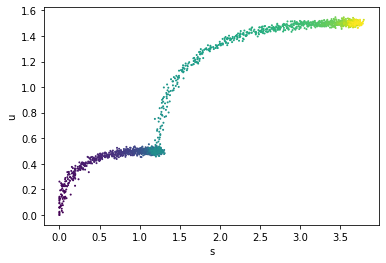

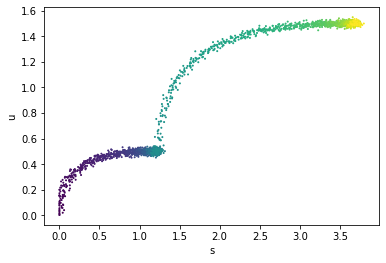

In [24]:
for gene in boost_data.gene_list.drop_duplicates():
    data = boost_data[boost_data.gene_list == gene].reset_index()
    plt.scatter(data['s0'], data['u0'], c=data.index, s=1)
    plt.xlabel("s")
    plt.ylabel("u")
    plt.show()

/var/folders/2p/2j0f_d_13815dk9jyzwnfl540000gp/T/ipykernel_32345/1047051892.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gene_info = gene_info.append({'gene_name':gene_name, 'type':"multi_path", 'alpha1':alpha1, 'alpha2':alpha2, 'beta1':beta1, 'beta2':beta2, 'gamma1':gamma1, 'gamma2':gamma2, 'path1_pct':path1_pct, 'path2_pct':path2_pct, 'samples':len(expr)}, ignore_index=True)
/var/folders/2p/2j0f_d_13815dk9jyzwnfl540000gp/T/ipykernel_32345/1047051892.py:175: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = anndata.AnnData(
/Users/pengzhizhang/miniconda3/envs/celldancer/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
 

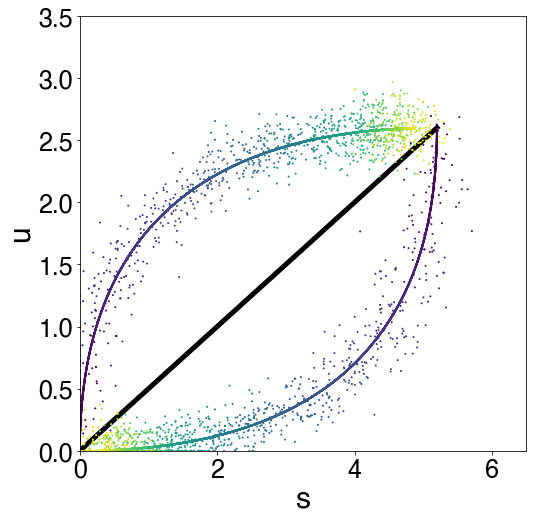

In [57]:

import matplotlib.pyplot as plt

SMALL_SIZE = 25
MEDIUM_SIZE = 30
BIGGER_SIZE = 40
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('font', family='helvetica')
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


boost_data = generate_forward(
    gene_num=1, 
    alpha=2.6,
    beta=1, 
    gamma=0.5, 
    sample=1000, 
    noise_level=0.5)

recession_data = generate(
    "backward",
    1, 
    2.6,
    0,
    1,
    0, 
    0.5,
    0,
    99.999,
    0,
    1000, 
    0,
    0.5)


boost_data_no_noise= generate_forward(
    gene_num=1, 
    alpha=2.6,
    beta=1, 
    gamma=0.5, 
    sample=10000, 
    noise_level=0.)

recession_data_no_noise = generate(
    "backward",
    1, 
    2.6,
    0,
    1,
    0, 
    0.5,
    0,
    100,
    0,
    10000, 
    0,
    0.)

for gene in boost_data.gene_list.drop_duplicates():
    data1 = boost_data[boost_data.gene_list == gene].reset_index()
    data2 = recession_data[recession_data.gene_list == gene].reset_index()
    data3 = boost_data_no_noise[boost_data_no_noise.gene_list == gene].reset_index()
    data4 = recession_data_no_noise[recession_data_no_noise.gene_list == gene].reset_index()
    
    fig, ax = plt.subplots(figsize=(8,8))
    ax.scatter(data1['s0'], data1['u0'], c=data1.index, s=1)
    ax.scatter(data2['s0'], data2['u0'], c=data2.index, s=1)
    ax.scatter(data3['s0'], data3['u0'], c=data3.index, s=1)
    ax.scatter(data4['s0'], data4['u0'], c=data4.index, s=1)
    ax.plot([0, 2.6/0.5],[0, 2.6/1], 'k-', zorder=-1, linewidth=5)

    ax.set_xlabel("s")
    ax.set_ylabel("u")
    ax.set_xlim(0,6.5)
    ax.set_ylim(0,3.5)
    #ax.set_aspect('equal')
    #ax.axis('scaled')



    plt.savefig("steady.png", dpi=600)